# Explore here

Cargamos librerias y CSV

In [29]:
#Importamos librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib
from sklearn.linear_model import LinearRegression

df = pd.read_csv("/workspaces/machine-learning-vicentepolo/data/raw/medical_insurance_cost.csv", sep= ',' )

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


Análisis de constantes

In [30]:
n_unicos = df.nunique()
n_unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

Revisión de duplicados

In [31]:
duplicadas = df[df.duplicated(keep=False)]

duplicadas



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.56
581,19,male,30.59,0,no,northwest,1639.56


In [32]:
df.drop(df[df.duplicated()].index, inplace=True)

In [33]:
df.duplicated().sum()

np.int64(0)

Comprobamos valores faltantes

<Axes: >

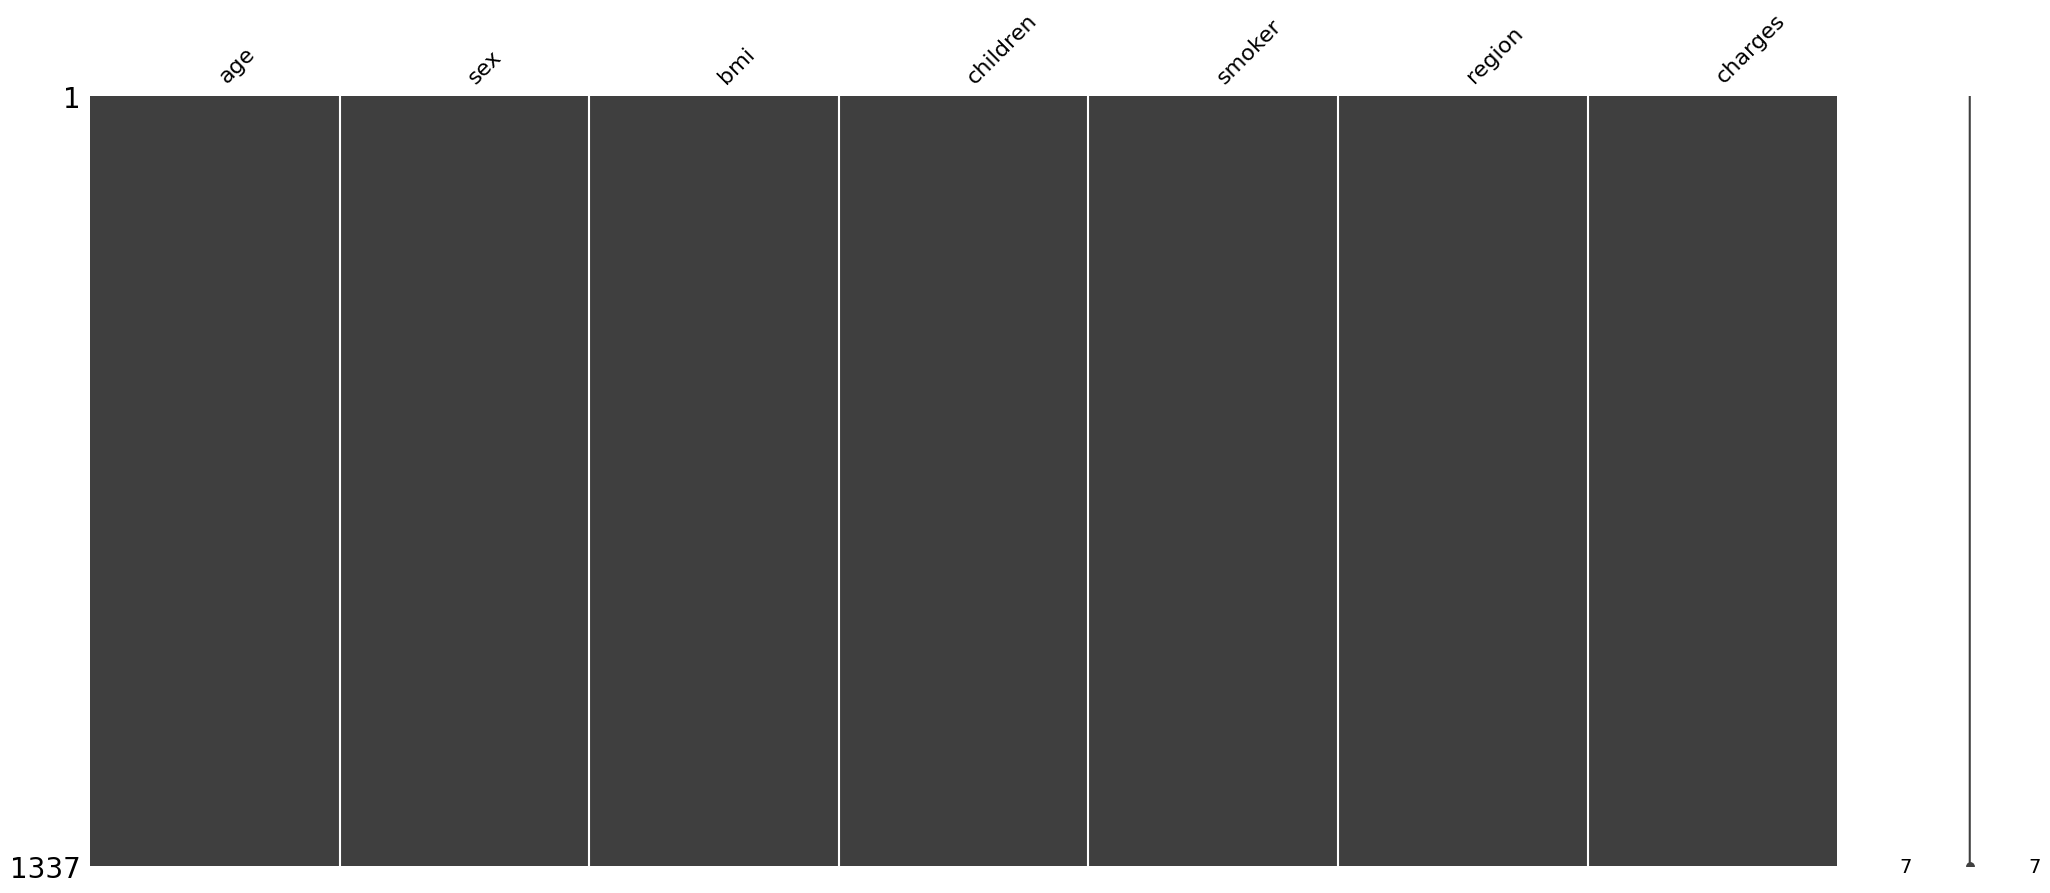

In [34]:
msno.matrix(df)

In [35]:
df.isnull().mean()*100

age        0.00
sex        0.00
bmi        0.00
children   0.00
smoker     0.00
region     0.00
charges    0.00
dtype: float64

Comprobación de columnas categóricas 

In [36]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Se entiende que charges va a ser la variable independiente. Hay que transformar el resto de valores a numéricos

In [37]:
df["sex"] = pd.factorize(df["sex"])[0]
df["smoker"] = pd.factorize(df["smoker"])[0]
df["region"] = pd.factorize(df["region"])[0]

In [38]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,0,0,16884.92
1,18,1,33.77,1,1,1,1725.55
2,28,1,33.00,3,1,1,4449.46
3,33,1,22.70,0,1,2,21984.47
4,32,1,28.88,0,1,2,3866.86


In [39]:
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [40]:
#Asignamos valores X e Y
X = df.drop(['charges'], axis=1)
y = df['charges']

Ajustar a un modelo de regresion lineal

In [41]:

X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de Cook para cada observación
cooks_distance = model.get_influence().cooks_distance


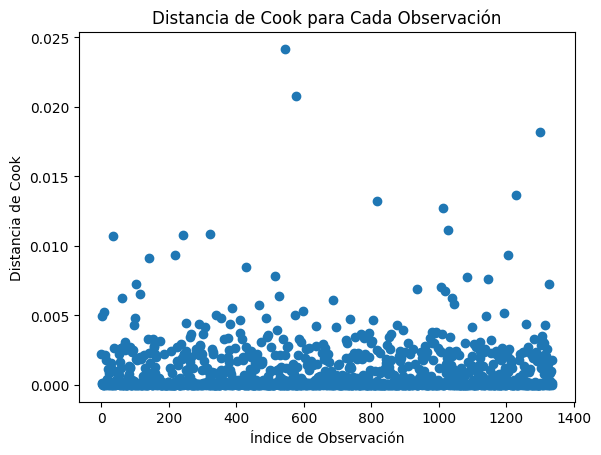

In [42]:

plt.scatter(range(len(cooks_distance[0])), cooks_distance[0])
plt.xlabel('Índice de Observación')
plt.ylabel('Distancia de Cook')
plt.title('Distancia de Cook para Cada Observación')

plt.show()


In [43]:
pto_corte = 4/len(df)

len(np.where(cooks_distance[0]>pto_corte)[0])

np.where(cooks_distance[0]>0.015)

(array([ 543,  577, 1299]),)

In [44]:
df.drop(np.where(cooks_distance[0]>pto_corte)[0])

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,0,0,16884.92
1,18,1,33.77,1,1,1,1725.55
2,28,1,33.00,3,1,1,4449.46
4,32,1,28.88,0,1,2,3866.86
5,31,0,25.74,0,1,1,3756.62
...,...,...,...,...,...,...,...
1333,50,1,30.97,3,1,2,10600.55
1334,18,0,31.92,0,1,3,2205.98
1335,18,0,36.85,0,1,1,1629.83
1336,21,0,25.80,0,1,0,2007.94


Dividimos data set entre train y test

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [47]:
print(f"Intercept (a): {model.intercept_}")
print(f"Coefficients (b): {model.coef_}")

Intercept (a): 11291.590752555612
Coefficients (b): [     0.            248.76407134    -99.69539417    312.60904469
    534.12087654 -23052.15275173    237.62514748]


In [48]:
y_pred = model.predict(X_test)
y_pred

array([ 8.08045019e+03,  5.59287112e+03,  1.43782987e+04,  3.17318195e+04,
        9.15835694e+03,  1.33610143e+04,  3.02576553e+04,  1.30864736e+03,
        1.08494254e+04,  1.13755485e+04,  1.04822214e+04,  3.31558608e+04,
        3.09123841e+04,  1.71688443e+04,  1.06361393e+04,  9.37424715e+03,
        3.96524338e+03,  3.19229863e+04,  3.08468457e+03,  5.47544373e+03,
        3.76844305e+03,  3.01552667e+04,  1.50768984e+04,  3.02746510e+04,
        3.10830548e+04,  5.52001772e+03,  3.56655758e+04,  3.63713163e+04,
        1.12979802e+04,  1.40664742e+04,  6.37519963e+03,  1.29381095e+04,
        6.79284837e+02,  1.19476924e+04,  3.97832706e+04,  1.21517558e+04,
        4.57717842e+03,  4.01652351e+03,  3.11475453e+04,  9.22301501e+03,
        6.86852604e+03,  3.00358113e+04,  3.49732855e+04,  1.21709787e+04,
        7.46262777e+03,  3.27014535e+03,  6.02195905e+03,  8.81742438e+03,
        4.32171874e+03,  9.25718479e+03,  6.82679737e+03,  1.18887556e+04,
        3.11350727e+04,  

In [49]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 35493102.61165051
Coefficient of determination: 0.8068466322629112
